In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, preprocessing
from tensorflow.keras.applications.vgg16 import preprocess_input
import matplotlib.pyplot as plt
import numpy as np
from random import choices
import random

In [2]:
import json
from pathlib import Path
import os

In [3]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

In [4]:
historiesDir = '.\histories' 
Path(historiesDir).mkdir(parents=True, exist_ok=True)

In [5]:
##############################CREATE MODEL############################

In [6]:
vgg = tf.keras.applications.vgg16.VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))

In [7]:
flatten = layers.Flatten()
dense1 = layers.Dense(units=1024, activation="relu", name='fc1')
drop1 = layers.Dropout(0.5, name="drop1")
dense2 = layers.Dense(units=1024, activation="relu", name='fc2')
drop2 = layers.Dropout(0.5, name="drop2")
fc = layers.Dense(units=5, activation="softmax", name='fc3') #-> five classes, softmax  für categorical crossentropy

inp = vgg.input
out = fc(drop2(dense2(drop1(dense1(flatten(vgg.output))))))

woundnet = tf.keras.Model(inp, out)
woundnet.summary()



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [8]:
wound1 = models.clone_model(woundnet)
wound1._name = 'wound1'
wound2 = models.clone_model(woundnet)
wound2._name = 'wound2'
wound3 = models.clone_model(woundnet)
wound3._name = 'wound3'

In [9]:
for layer in wound1.layers[:6]:
        layer.trainable = False
        
for layer in wound2.layers[:10]:
        layer.trainable = False
        
for layer in wound3.layers[:14]:
        layer.trainable = False
        

In [10]:
##################################LOAD DATA#########################################################

In [12]:
img_height=224
img_width=224

train_ds = tf.keras.preprocessing.image_dataset_from_directory('.\\images\\train', label_mode='categorical', class_names=['eiternd', 'entzündet','Gesunde Haut', 'nekrotisch', 'ohne Kategorie'], image_size=(img_height, img_width), shuffle=True, batch_size=32)

val_ds = tf.keras.preprocessing.image_dataset_from_directory('.\\images\\val', label_mode='categorical', class_names=['eiternd', 'entzündet','Gesunde Haut', 'nekrotisch', 'ohne Kategorie'], image_size=(img_height, img_width), shuffle=True, batch_size=32)


Found 1650 files belonging to 5 classes.
Found 132 files belonging to 5 classes.


In [13]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 224, 224, 3)
(32, 5)


In [14]:
nz_ds_train = train_ds.map(lambda x, y: (preprocess_input(x), y))
print(type(nz_ds_train))
for image_batch, labels_batch in nz_ds_train:
    first_image = image_batch[1]
    print(np.min(first_image), np.max(first_image))
    break

nz_ds_val = val_ds.map(lambda x, y: (preprocess_input(x), y))

<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>
-121.68 151.061


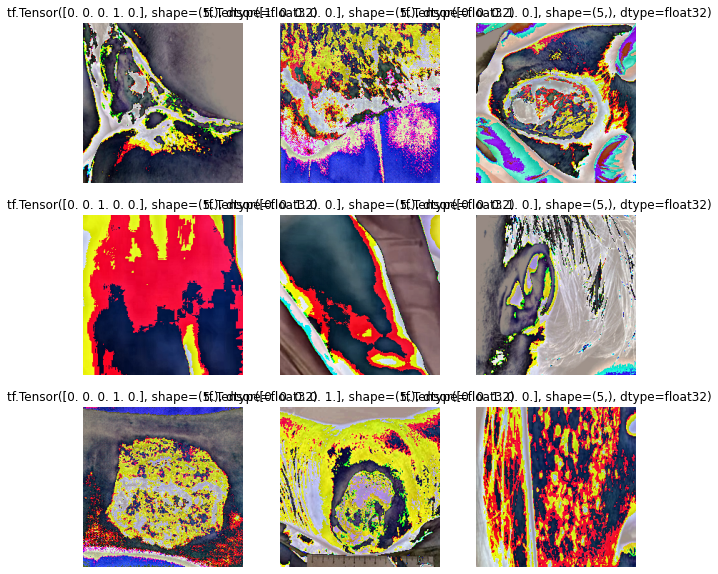

In [16]:
plt.figure(figsize=(10, 10))
for images, labels in nz_ds_val.take(1):

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(str(labels[i]))
        plt.axis("off")

In [17]:
val_batches = tf.data.experimental.cardinality(nz_ds_val)
test_ds = nz_ds_val.take(val_batches // 2)
nz_ds_val_splitted = nz_ds_val.skip(val_batches // 2)


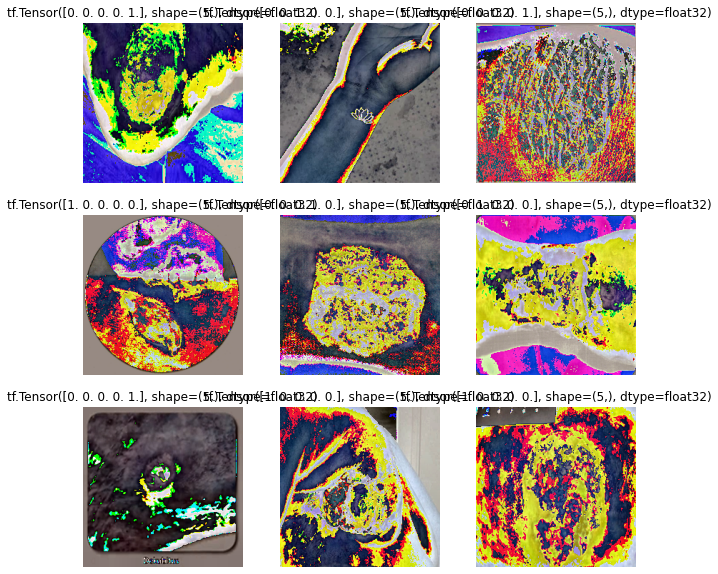

In [18]:
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(str(labels[i]))
        plt.axis("off")

In [19]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(nz_ds_val_splitted))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))
print('Number of training batches: %d' % tf.data.experimental.cardinality(nz_ds_train))

Number of validation batches: 3
Number of test batches: 2
Number of training batches: 52


In [20]:
AUTOTUNE = tf.data.AUTOTUNE

nz_ds_train = nz_ds_train.prefetch(buffer_size=AUTOTUNE)
nz_ds_val_splitted = nz_ds_val_splitted.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [21]:
##################################START LEARNING####################################################

In [22]:
deepwound.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

NameError: name 'deepwound' is not defined

In [ ]:
history1 = deepwound.fit(train_ds, validation_data=val_ds, epochs=30, batch_size=64)

In [ ]:
history1_dict = history1.history
json.dump(history1_dict, open('{}\\{}'.format(historiesDir, 'history1'), 'w'))

In [14]:
deepwound.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
history2 = deepwound.fit(train_ds, validation_data=val_ds, epochs=50, batch_size=64)

In [ ]:
history2_dict = history2.history
json.dump(history2_dict, open('{}\\{}'.format(historiesDir, 'history2'), 'w'))

In [21]:
#####################################TESTING, NOT THE MODEL BUT MY CODE#############################################################

In [23]:
wound1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])
wound2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
wound3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])


In [25]:
history3 = wound1.fit(nz_ds_train, validation_data=nz_ds_val_splitted, epochs=1, batch_size=32)

52/52 [==============================] - 293s 6s/step - loss: 1.5843 - accuracy: 0.3442 - val_loss: 1.5222 - val_accuracy: 0.3676


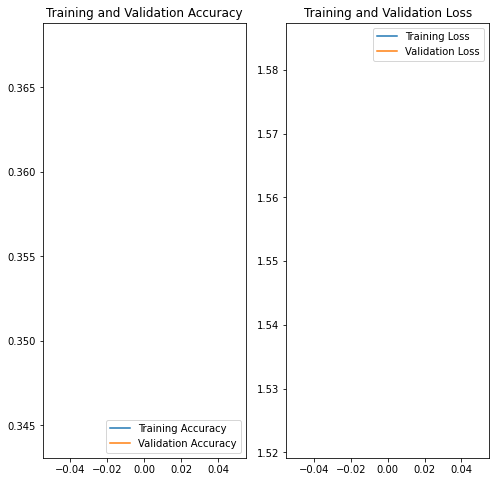

In [27]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [22]:
history3_dict = history3.history
json.dump(history3_dict, open('{}\\{}'.format(historiesDir, 'history3'), 'w'))

In [ ]:
###########################Testing##########################

In [50]:
test_wound = tf.keras.models.load_model('.\\training\\09.07\\models\\deepwound')

In [38]:
pred = test_wound.predict(test_ds)

In [39]:
def decode(preds):
    ##stark inspiriert an der methode tf.keras.applications.vgg16.decode_predictions(preds, top=5)
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-1:][::-1]
        result = [tuple(str(i)) + (pred[i],) for i in top_indices]
        results.append(result)
    return results[0][0]

In [42]:
print(len(res))

64


In [49]:

pred = test_wound.predict(test_ds)
y = np.concatenate([y for x, y in test_ds], axis=0)
hit = 0
size = len(pred)
for i in range(size): 
    if(decode([pred[i]])[0] is decode([y[i]])[0]):
              hit += 1
print('acc: ' + hit/size)

0.25


In [424]:
##################Exporting Model#######################

In [30]:
inputs = tf.keras.Input(shape=(224, 224, 3))

y1 = wound1(inputs)
y2 = wound2(inputs)
y3 = wound3(inputs)
outputs = layers.average([y1, y2, y3])
deepwound = tf.keras.Model(inputs=inputs, outputs=outputs)

In [31]:
deepwound.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
wound1 (Functional)             (None, 5)            41460549    input_2[0][0]                    
__________________________________________________________________________________________________
wound2 (Functional)             (None, 5)            41460549    input_2[0][0]                    
__________________________________________________________________________________________________
wound3 (Functional)             (None, 5)            41460549    input_2[0][0]                    
____________________________________________________________________________________________

In [14]:
deepwound.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
nz_ds_test = test_ds.map(lambda x, y: (preprocess_input(x), y))
results = deepwound.evaluate(nz_ds_test)

NameError: name 'test_ds' is not defined

In [40]:
print("##############results:{}".format(results))

##############results:[0.6666924953460693, 0.0]


In [17]:
##save deepwound

path = './models'
Path(path).mkdir(parents=True, exist_ok=True)
deepwound.save(path)

E:\Users\korbi\Desktop\BA\cnns\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: ./models\assets


In [18]:
##opencv

pb_model_path = "./models/opencv/"
pb_model_name = "deepwound.pb"
os.makedirs(pb_model_path, exist_ok=True)
tf_model_graph = tf.function(lambda x: deepwound(x))
tf_model_graph = tf_model_graph.get_concrete_function(
    tf.TensorSpec(vgg.inputs[0].shape, vgg.inputs[0].dtype))
frozen_tf_func = convert_variables_to_constants_v2(tf_model_graph)
frozen_tf_func.graph.as_graph_def()
tf.io.write_graph(graph_or_graph_def=frozen_tf_func.graph,
                  logdir=pb_model_path,
                  name=pb_model_name,
                  as_text=False)

'./models/opencv/deepwound.pb'